In [34]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from collections import defaultdict
from io import StringIO
from scipy.optimize import curve_fit

plt.rcParams["figure.figsize"] = (15,8) #set size of plot

# Start working

We start off by importing the **Food Balance Sheet** from FAO Dataset (African countries only). 

In [35]:
FAO_food_balance = pd.read_csv("Data/FoodBalanceSheets_E_Africa_1.csv",encoding='latin-1');

Firstly, we will **remove** all the columns with title **"Y----F"** as they contain informations about how the data were obtained (Calculated, Regression, Aggregate, FAO Estimation). In this context we will consider that FAO is an highly renowned Agency and hence we can assume these values are truthful without loss of generality. Furthermore we thought that it would be very handy to have numbers as columns representing years instead of **"Y----"**. We proceed on removing the letter **Y**.

In [36]:
col_to_drop = FAO_food_balance.columns[FAO_food_balance.columns.str.endswith("F")]; #creating a list of columns to be removed
FAO_food_balance = FAO_food_balance.drop(columns=col_to_drop);
FAO_food_balance.columns=FAO_food_balance.columns.str.replace("Y","")

Secondly, we replace all the **NAN** values with **0** as Item was not available.

In [37]:
FAO_food_balance = FAO_food_balance.fillna(0);

The third step to complete **the cleaning** of FAO_food_balance consists into adapt names of countries in order to have consistency along our different dataframes. Since some countries changed their name over the years we will rename them. In particular, **Swaziland** to **Eswatini** and **South Africa** to **Southern Africa**.

In [38]:
FAO_food_balance['Area'] = FAO_food_balance['Area'].replace("Swaziland", "Eswatini");
FAO_food_balance['Area'] = FAO_food_balance['Area'].replace("South Africa", "Southern Africa");
FAO_food_balance.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,1961,1962,1963,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,4,Algeria,2501,Population,511,Total Population - Both sexes,1000 persons,11561.0,11845.0,12136.0,...,33461.0,33961.0,34507.0,35097.0,35725.0,36383.0,37063.0,37763.0,38482.0,39208.0
1,4,Algeria,2511,Wheat and products,5511,Production,1000 tonnes,686.0,1507.0,1590.0,...,2731.0,2415.0,2688.0,2319.0,1111.0,2953.0,2605.0,2555.0,3432.0,3299.0
2,4,Algeria,2511,Wheat and products,5611,Import Quantity,1000 tonnes,469.0,501.0,374.0,...,5123.0,5697.0,4987.0,4885.0,6508.0,5757.0,5109.0,7487.0,6385.0,6343.0
3,4,Algeria,2511,Wheat and products,5072,Stock Variation,1000 tonnes,353.0,-409.0,-408.0,...,-456.0,-606.0,-459.0,-1.0,156.0,-484.0,515.0,-1050.0,-350.0,-180.0
4,4,Algeria,2511,Wheat and products,5911,Export Quantity,1000 tonnes,46.0,12.0,33.0,...,7.0,13.0,7.0,14.0,24.0,37.0,39.0,5.0,5.0,2.0


Analysing our DataFrame **FAO_food_balance** we can see that it's already well structured since it contains many key - value couples such as **Item Code - Item** and **Element Code - Element** . More specifically, we will take advantage of this structure to filter out only rows characterized by **Grand total** as an **Item** and **Food supply (kcal/capita/day)** as an **Element**. The corresponding key-values are **(Item Code, 2901) and (Element Code, 664)**.
A reference to the documentation in the [FAO Website](http://www.fao.org/faostat/en/#data/FBS) explains extensevely the legend for Element Code and Element Item. 

In order to keep our original Dataframe **FAO_food_balance** as a reference we create a new Dataframe **FAO_food_supply** in which we keep just **countries** and **food supplies** for every **year**.

In [39]:
FAO_food_supply = FAO_food_balance[(FAO_food_balance["Item Code"] == 2901) & (FAO_food_balance["Element Code"] == 664)];
FAO_food_supply = FAO_food_supply.drop(columns=["Area Code","Item Code","Item","Element Code","Element", "Unit"])

We can now group group by **Area** and see the supplies derived from each item available in countries for that particular year.

In [40]:
FAO_food_supply = FAO_food_supply.set_index("Area")
FAO_food_supply.head()

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,
Algeria,1619.0,1569.0,1528.0,1540.0,1591.0,1571.0,1647.0,1706.0,1705.0,1675.0,...,2987.0,2958.0,3047.0,3041.0,3048.0,3110.0,3142.0,3217.0,3272.0,3296.0
Angola,1798.0,1819.0,1853.0,1862.0,1877.0,1890.0,1921.0,1856.0,1946.0,1965.0,...,2030.0,2077.0,2119.0,2173.0,2245.0,2303.0,2345.0,2407.0,2384.0,2473.0
Benin,1736.0,1758.0,1703.0,1669.0,1812.0,1804.0,1833.0,1935.0,1871.0,1812.0,...,2461.0,2435.0,2450.0,2564.0,2521.0,2565.0,2555.0,2598.0,2610.0,2619.0
Botswana,1976.0,1909.0,1972.0,2001.0,2005.0,1947.0,2010.0,2052.0,2013.0,2035.0,...,2191.0,2198.0,2150.0,2166.0,2184.0,2199.0,2234.0,2273.0,2342.0,2326.0
Burkina Faso,1326.0,1308.0,1452.0,1555.0,1571.0,1560.0,1587.0,1602.0,1604.0,1546.0,...,2505.0,2463.0,2559.0,2546.0,2588.0,2639.0,2681.0,2664.0,2707.0,2720.0


In order to check for anomalies in our data, we would like to analyze the **timeline**. We therefore transpose the dataframe and plot the timeline of how food supply in different countries evolved. Legend was suppressed as it is too large.

In [41]:
FAO_food_supply = FAO_food_supply.transpose();

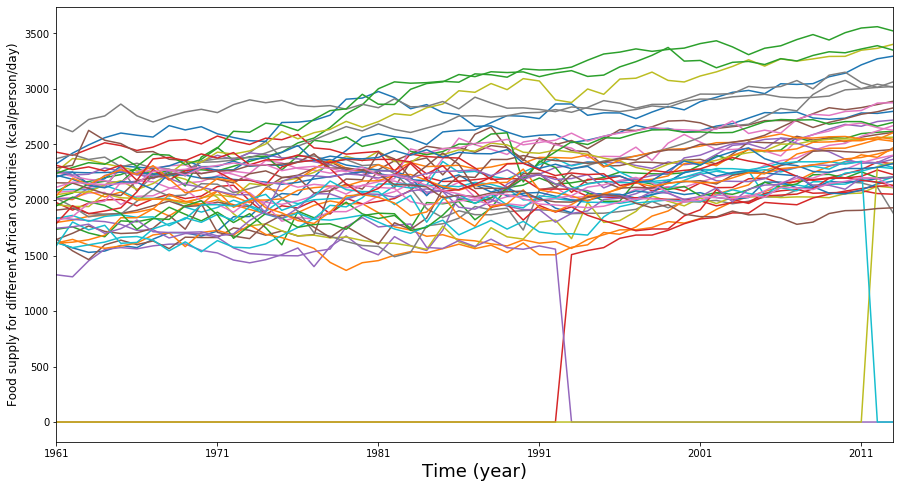

In [42]:
FAO_food_supply.plot.line(legend = False)
plt.xlabel("Time (year)", fontsize=18)
plt.ylabel("Food supply for different African countries (kcal/person/day)", fontsize=12);

This analysis shows that there are two inconsistencies. We therefore check for countries containing values equal to zero.

In [44]:
FAO_food_supply.columns.values[(FAO_food_supply == 0).any()]

array(['Ethiopia', 'Ethiopia PDR', 'Sudan', 'Sudan (former)'],
      dtype=object)

We notice that **Sudan** and **Ethiopia** appear twice as "Sudan" and "Sudan (former)" and "Ethiopia" and "Ethiopia PDR" respectively. This is due to the fact that South Sudan gained independence in 2011 (reference to https://en.wikipedia.org/wiki/South_Sudan), and the foundation of the Federal Democratic Republic of Ethiopia (https://en.wikipedia.org/wiki/Ethiopia) in 1991. From then on, Ethiopia PDR was listed as Ethiopia. With food supply being consistently constant even after division, the newly introduced country "Sudan" is assumed to further on have accounted for both countries. For this reason, we will consider them to be one single country. 
Consequently, the two countries' data is merged into one continuous set each.

In [274]:
FAO_food_supply_cleared = FAO_food_supply.copy()
FAO_food_supply_cleared['Sudan'] += FAO_food_supply_cleared['Sudan (former)']
FAO_food_supply_cleared = FAO_food_supply_cleared.drop('Sudan (former)', 1)
FAO_food_supply_cleared['Ethiopia'] += FAO_food_supply_cleared['Ethiopia PDR']
FAO_food_supply_cleared = FAO_food_supply_cleared.drop('Ethiopia PDR', 1)

Let's plot the newly generated data to make sure it makes sense..

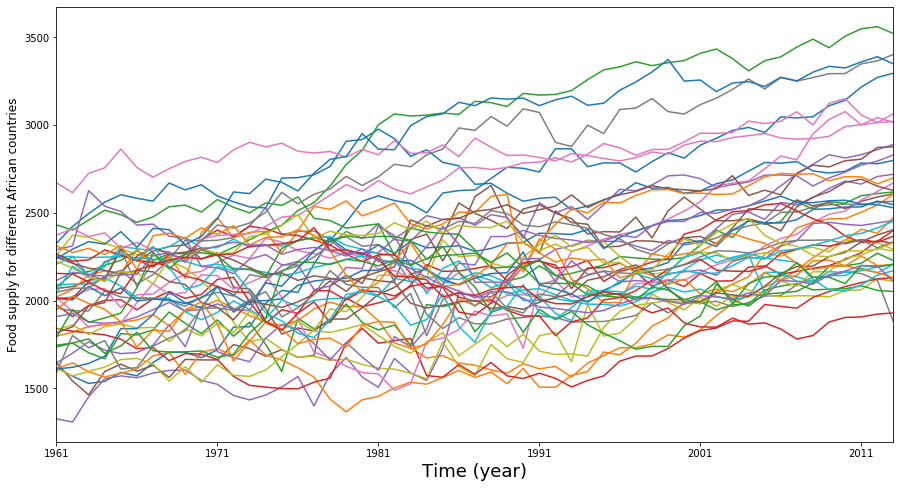

In [275]:
FAO_food_supply_cleared.plot.line(legend = False)
plt.xlabel("Time (year)", fontsize=18)
plt.ylabel("Food supply for different African countries", fontsize=12);

Next, we want to add more columns representing future years until 2030 to prepare cells for extrapolation to make predictions about possible scenarios.

In [276]:
FAO_food_supply_cleared = FAO_food_supply_cleared.transpose();

In [277]:
for i in np.arange(2014,2031):
    FAO_food_supply_cleared[i] = np.nan

In [278]:
FAO_food_supply_cleared = FAO_food_supply_cleared.transpose();

#### Extrapolation 
First of all, we want to simulate data until 2020 to match the population data. Furthermore, we also want to be able to make predicitions for individual countries to assess if they might run into food shortages in the near future. For extrapolating, we are not considering value of the entire timeline, as past crisis and wars should not influence the recent trend in food supply development. We chose to restrict the extrapolation basis to the years 2000-2013 and use a linear function in order to avoid too much fluctuation, especially negative values resulting from an (exponential decay

In [267]:
FAO_recent = FAO_food_supply_cleared.iloc[39:]
def func(x, e, f):
    return e * x + f 
#return a * (x ** 5) + b * (x ** 4) + c * (x ** 3) +  d * (x ** 2) + e * x + f 

# Initial parameter guess, just to kick off the optimization
guess = (0.5, 0.5)

# Create copy of data to remove NaNs for curve fitting
fit_df = FAO_recent.dropna()

# Place to store function parameters for each column
col_params = {}

# Curve fit each column
for col in fit_df.columns:
    # Get x & y
    x = fit_df.index.astype(float).values
    y = fit_df[col].values
    # Curve fit column and get curve parameters
    params = curve_fit(func, x, y, guess)
    # Store optimized parameters
    col_params[col] = params[0]

# Extrapolate each column
for col in FAO_food_supply_cleared.columns:
    # Get the index values for NaNs in the column
    x = FAO_food_supply_cleared[pd.isnull(FAO_food_supply_cleared[col])].index.astype(float).values
    # Extrapolate those points with the fitted function
    FAO_food_supply_cleared[col][x] = func(x, *col_params[col])

# Display result
print ('Extrapolated data:')
print (FAO_food_supply_cleared)


#print ('Data was extrapolated with these column functions:')
#for col in col_params:
#    print ('f_{}(x) = {:0.3e} x^3 + {:0.3e} x^2 + {:0.4f} x + {:0.4f}'.format(col, *col_params[col]))

Extrapolated data:
Area      Algeria       Angola        Benin     Botswana  Burkina Faso  \
1961  1619.000000  1798.000000  1736.000000  1976.000000   1326.000000   
1962  1569.000000  1819.000000  1758.000000  1909.000000   1308.000000   
1963  1528.000000  1853.000000  1703.000000  1972.000000   1452.000000   
1964  1540.000000  1862.000000  1669.000000  2001.000000   1555.000000   
1965  1591.000000  1877.000000  1812.000000  2005.000000   1571.000000   
...           ...          ...          ...          ...           ...   
2026  3704.314284  3168.457050  2998.657143  2519.428571   3143.914286   
2027  3737.828570  3220.762539  3025.331868  2536.098901   3174.646154   
2028  3771.342856  3273.068029  3052.006593  2552.769231   3205.378022   
2029  3804.857141  3325.373519  3078.681319  2569.439560   3236.109890   
2030  3838.371427  3377.679009  3105.356044  2586.109890   3266.841758   

Area   Cabo Verde     Cameroon  Central African Republic         Chad  \
1961  1647.000000  

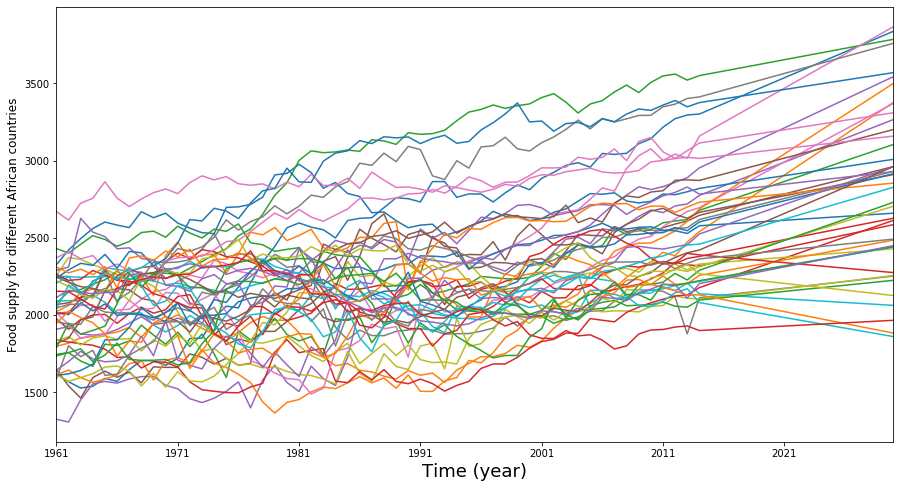

In [268]:
FAO_food_supply_cleared.plot.line(legend = False)
plt.xlabel("Time (year)", fontsize=18)
plt.ylabel("Food supply for different African countries", fontsize=12);

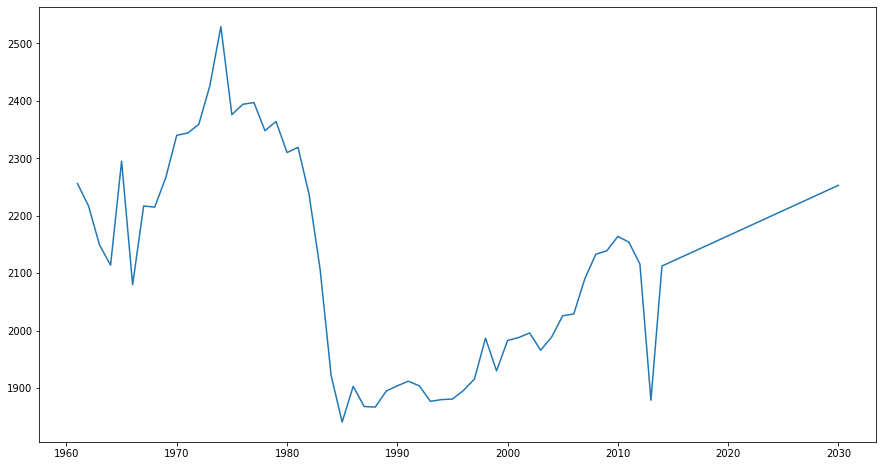

In [271]:
x = FAO_food_supply_cleared.index.values.astype(float)
y = FAO_food_supply_cleared["Central African Republic"].values.astype(float)
plt.plot(x,y)

## Finding calories needed for each country
The first need we need to do for our analysis is to find the total calories demand in each country... **write other things to start**

### Working on calories demand  
We load the calories demand datasets we scraped for the webpage [Calories](https://health.gov/dietaryguidelines/2015/guidelines/appendix-2/), datasets will we working on to match with population data

In [358]:
male_calory_demand = pd.read_excel("data/calories_demand.xlsx",header =None, sheet_name=0, names=['age', 'sedentary', 'moderate', 'active'])

In [359]:
females_calory_demand =  pd.read_excel("data/calories_demand.xlsx",header =None, sheet_name=1, names=['age', 'sedentary', 'moderate', 'active'])

In order to better work with the information we have collected, we will make some simplifications on the data. Mainly, we will:
- in the calories demands database, assume an average of necessary input per age
- group the ages into ranges that match the ranges provided in the World Population Database

In [360]:
def input_average(data_frame):
    result = data_frame.copy()
    result['input (KCal)'] = result.mean(axis=1) #computing the mean
    result = result.drop(columns=['sedentary', 'moderate', 'active']) #we keep only the mean
    return result

In [361]:
male_calories_avg = input_average(male_calory_demand)
females_calories_avg = input_average(females_calory_demand)

We have now obtained a caloric demand average for simpler calculations in the future and stored in the two precedent datasets.  
Now, we need a  way to match the age groups in this dataframe, to the ones in the population database we obtained. As such, let's analyse how ages are represented in our calory demand dataframes.

In [362]:
male_calories_avg['age'].unique()

array([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       '19-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50',
       '51-55', '56-60', '61-65', '66-70', '71-75', '76 and up', nan],
      dtype=object)

We can see there are ranges of ages with different sizes (which makes sense, because different age groups have different caloric needs). We'll present a function that creates one row per individual age

In [363]:
def single_age(age_range):
    if type(age_range) ==  float: # nans are the only floats in the age column
        return -1
    elif type(age_range) == int:
        return age_range
    elif re.search('\d-\d', age_range):
        group = age_range.split('-')
        return list(range(int(group[0]), int(group[1])+1))
    elif age_range == "76 and up":
        return list(range(76, 101+1))

In [364]:
def explode_age(data_frame):
    accum = []
    for i in data_frame.index:
        row = data_frame.loc[i]
        single = single_age(row['age'])
        if single == -1: # we ignore the nan values, as their rows are empty
            continue
        if type(single) == int:
            accum.append((single, row['input (KCal)']))
        elif type(single) == list:
            accum.extend([(x, row['input (KCal)']) for x in single]) 
    return pd.DataFrame(accum, columns=data_frame.columns)

We apply the function to our two dataframe:

In [365]:
male_explode = explode_age(male_calories_avg)
female_explode = explode_age(females_calories_avg)

In [366]:
male_explode['age'].unique()

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101], dtype=int64)

Ages are now unique in each dataframe ( `male_explode` and `female_explode` ) and there's a caloric input value for each of them.

#### Joao please comment the next two function and the code in the cells

The last step to allow the match with the population database is to build the **same age groups** we have in that set.  
We do this in the next two functions:

In [367]:
def group(age):
    i = int(5*(age//5))
    return "{}-{}".format(i, i+4)

In [368]:
def compress_ages(data_frame):
    accum = defaultdict(list)
    for i in data_frame.index:
        row = data_frame.loc[i]
        g_id = group(row['age'])
        if g_id == "100-104":
            g_id = "100+"
        accum[g_id].append(row['input (KCal)'])
    for i in accum:
        accum[i] = sum(accum[i]) / len(accum[i])
    return pd.DataFrame.from_dict(accum, orient='index')

We can lastly apply the functions to the dataframes:

In [369]:
new_male_need = compress_ages(male_explode)
new_female_need = compress_ages(female_explode)

We also use the age group as new index and rename the columns:

In [370]:
new_male_need.index.name = 'age_group'
new_male_need = new_male_need.rename(columns={0: 'input (KCal)'})
new_female_need.index.name = 'age_group'
new_female_need = new_female_need.rename(columns={0: 'input (KCal)'})

Let's see the result we have achieved and collected in our matchable dataframe `new_male_need` and `new_female_need`

In [371]:
new_male_need.head()

,input (KCal)
age_group,
0-4,1222.222222
5-9,1613.333333
10-14,2133.333333
15-19,2760.000000
20-24,2746.666667


## Computing total calories by matching 

**We now move on the matching with the *World Population Database* (United Nation) to compute the total calories needed in each country since 1950 to 2020**  
Matching with a precise dataset like this one is essential to take count of the demographics inside each country  
  
  
Firstly, we load the list of African countries (to filter the DB) and the two Databases (one for males, the other for females)  
*A note*: the values in the population dataframe are reported in **thousands**

In [372]:
with open ("data/african_countries.txt",'r') as af_c:
    af_countries = [line.rstrip() for line in af_c] #loading list

We need to check if the FAO Database contains data regarding **every country** in Africa. We will check the instection with the list **af_countries**.

In [373]:
af_to_remove = list(set(af_countries)- set(FAO_food_supply_cleared.columns.values))
print("List of countries for which no data is available: "+ str(af_to_remove))

List of countries for which no data is available: ['Mayotte', 'Burundi', 'Equatorial Guinea', 'Western Sahara', 'Eritrea', 'Somalia', 'South Sudan', 'Democratic Republic of the Congo', 'Comoros', 'RÃ©union', 'Seychelles', "CÃ´te d'Ivoire", 'Libya']


As expetected many countries we not present in the FAO Database. The countries we will delete are the following: **Eritrea, Burundi, Comoros, Democratic Republic of the Congo, Equatorial Guinea, Libya ,Seychelles, Western Sahara, South Sudan, and Somalia**. In particular, **Mayotte** and **Réunion** are two indipendent French islands so they will be removed as well.

In [374]:
af_countries = [i for i in af_countries if not i in af_to_remove]
af_to_remove = list(set(af_countries)- set(FAO_food_supply_cleared.columns.values))
print("List of countries for which no data is available: "+ str(af_to_remove))

List of countries for which no data is available: []


Loading and cleaning the dataset to be prepared for merging (they represent unuseful columns with long names)

In [375]:
#loading datasets
pop_male = pd.read_excel("data/POPULATION_BY_AGE_MALE.xlsx", sheet_name="ESTIMATES")
pop_female = pd.read_excel("data/POPULATION_BY_AGE_FEMALE.xlsx", sheet_name="ESTIMATES")

In [376]:
#cleaning male population dataset
pop_male.drop(columns=["Index", "Variant", "Notes", "Country code", "Type", "Parent code"], inplace=True)
pop_male.rename(columns={"Reference date (as of 1 July)": "year", "Region, subregion, country or area *": "country"}, inplace=True)
#taking only african countries
pop_male = pop_male[pop_male['country'].isin(af_countries)]

#cleaning female dataset
pop_female.drop(columns=["Index", "Variant", "Notes", "Country code", "Type", "Parent code"], inplace=True)
pop_female.rename(columns={"Reference date (as of 1 July)": "year", "Region, subregion, country or area *": "country"}, inplace=True)
#only african
pop_female = pop_female[pop_female['country'].isin(af_countries)]

Now we multiply each column of the population data (as we said, in thousand) for each matching `age_group` in the calories table (that here we squeeze to allow the multiplication, similar to a transpose rows/columns of the dataset).  
We obtain two datasets: `total_cal_male` and `total_cal_female` reporting total calories needed for **each country in each year per age group per gender**

In [377]:
#total calories male
pop_mal_mult = pop_male.drop(columns=["country", "year"])
male_mult_res = pop_mal_mult.multiply(new_male_need.squeeze()) # squeeze adapts the dimension of the dataframe
#rejoin with old dataframe and delete old column (just population)
total_cal_male = pop_male.join(male_mult_res, lsuffix="_old")
total_cal_male = total_cal_male[total_cal_male.columns[~total_cal_male.columns.str.endswith('_old')]]

In [378]:
#total calories female
pop_fem_mult = pop_female.drop(columns=["country", "year"])
female_mult_res = pop_fem_mult.multiply(new_female_need.squeeze())
total_cal_female = pop_female.join(female_mult_res, lsuffix="_old")
total_cal_female = total_cal_female[total_cal_female.columns[~total_cal_female.columns.str.endswith('_old')]]

Once we have the calories needed for both gender, we can add them together easily to achieve total calories needed for **each country in each year per age group**, and we collect them in the dataframe `total_cal_ages`

In [379]:
#copy the male inside the total (to mantain country and year columns) and sum with female
total_cal_ages = total_cal_male.copy()
sum_ind = total_cal_ages.columns[2:]
total_cal_ages[sum_ind] = total_cal_ages[sum_ind] + total_cal_female[sum_ind]

To find the total calories needed for **each country in each year** we then proceed to the sum over all the age groups, collected in `total_cal`

In [380]:
total_cal = total_cal_ages.copy()
sum_ind = total_cal.columns[2:]

#computing sum of cal over ages, removing ages
total_cal['Calories'] = total_cal[sum_ind].sum(axis=1)
total_cal.drop(columns=sum_ind, inplace=True)

The values proposed up to here **need to be scaled appropriartely**, as the total amount of calories should be multiplied by 1000 to take in account the value reported in the population dataset.  
Instead of dealing with large number (up to order of $10^9$ Kcal), we decide to divide another time by 1000.  
The reader is so advised that from now on all the calories will be reported in **Gcal** (I'm not totally sure, check together ahah) 

In [381]:
change_col = total_cal_ages.columns[2:] #index for the first 3 dataframes are the same
total_cal_male[change_col] = total_cal_male[change_col]/1000
total_cal_female[change_col] = total_cal_male[change_col]/1000
total_cal_ages[change_col] = total_cal_male[change_col]/1000
total_cal['Calories'] = total_cal['Calories']/1000

Drawing a sample of the final dataframe..

In [382]:
total_cal.head()

,country,year,Calories
420,Djibouti,1950,121.291427
421,Djibouti,1955,138.432262
422,Djibouti,1960,166.978938
423,Djibouti,1965,227.616138
424,Djibouti,1970,313.232320


#### Summing up to now
* We have defined a reasonable amount of calories needed for each gender and each group by taking average
* We collected these values in `new_male_need` and `new_female_need`
* We loaded the population of the African countries from the United Nation Dataset 
* We matched the population for the kcal needed by each age group. From this matching we build 4 different datasets, with different granularity levels:  
`total_cal_male`, `total_cal_female`, `total_cal_ages`, `total_cal`
* We changed the scale of our final dataframes to easily work with large numbers